## DataLoader

In [1]:
from generator import ProdKernel,FKernel,generate_conv
from netCDF4 import Dataset
import numpy as np
import os

datafolder ='Data'
fin = Dataset(os.path.join(datafolder, 'f522_dh.trainingdata_in.lcv.20190401_0000z.nc4'))
fout = Dataset(os.path.join(datafolder, 'f522_dh.trainingdata_out.lcv.20190401_0000z.nc4'))
x = fin.variables
y = fout.variables

batch_size = 64
HNn = [128,64,16,4] # hidden layer size
header = list(x.keys())[6:] # variables are relevant after "time"
kernels = []
testprop = 0.9
seed = 0
n,p = x['Xdim'].shape[0],x['Ydim'].shape[0]

np.random.seed(seed)
d = len(header) + np.sum(np.array( [len(k.header) for k in kernels]  ))
batch_per_epoch = int(n*p / batch_size)


In [2]:
class Preprocess(object):
    def __init__(self):
        self.fitted=False
        pass
        
    def apply(self,x):
        return(x)

    def fit(self,x):
        self.fitted=True
        return(x)
    
    def __str__(self):
        return('type : {} \nfitted : {} \nvalues : {} \n  ')
    
class Normalizer(Preprocess):
    def __init__(self):
        super().__init__()
        self.m = 0
        self.std = 1
    
    def apply(self,x):
        x-=self.m
        x/=self.std
        return(x)

    def fit(self,x):
        self.fitted=True
        self.m = np.mean(x)
        self.std = np.std(x)
        
    def __str__(self):
        return super().__str__().format("Normalizer", self.fitted, (self.m, self.std))
    
class Zero_One(Preprocess):
    def __init__(self):
        super().__init__()
        self.max=1
        self.min=1
    
    def apply(self,x):
        x-=self.min
        x/=(self.max-self.min)
        return(x)
        
    def fit(self,x):
        self.fitted=True
        self.min = np.min(x)
        self.max = np.max(x)

    def __str__(self):
        return super().__str__().format("Zero_One", self.fitted, (self.max, self.min))   

In [40]:
class DictPrepross(object):
    def __init__(self, header, functions):
        self.dict=dict()
        for i,h in enumerate(header):
            self.dict[h]=functions[i]
    
    def fitonNetCDF(self, data_in):
        for k in self.dict.keys():
            self[k].fit(data_in[k][:])

    def apply(self,x,h):
        if(h in self.dict.keys()):
            return(self[h].apply(x))
        else:
            return(x)
    
    def __getitem__(self,k):
        return self.dict[k]

    def __str__(self):
        out =''
        for h in self.dict.keys():
            out = out + '{} : {}'.format(h, str(self[h]))+'\n'
        return out

In [41]:
header = ["ql","qi","q","rl","ri","ts","t", "pl","emis","o3"]
fct = []
for i in range(5):
    fct.append(Zero_One())
for j in range(5):
    fct.append(Normalizer())
    
D = DictPrepross(header, fct)
del(fct)
D.fitonNetCDF(x)

In [42]:
print(D)

ql : type : Zero_One 
fitted : True 
values : (0.001, 0.0) 
  
qi : type : Zero_One 
fitted : True 
values : (0.001, 0.0) 
  
q : type : Zero_One 
fitted : True 
values : (0.023239478, 5.5362413e-31) 
  
rl : type : Zero_One 
fitted : True 
values : (2.1e-05, 5e-06) 
  
ri : type : Zero_One 
fitted : True 
values : (0.00010348039, 1.5e-05) 
  
ts : type : Normalizer 
fitted : True 
values : (287.45782, 14.984612) 
  
t : type : Normalizer 
fitted : True 
values : (244.74854, 28.761246) 
  
pl : type : Normalizer 
fitted : True 
values : (30265.254, 35708.36) 
  
emis : type : Normalizer 
fitted : True 
values : (0.98675406, 0.012409567) 
  
o3 : type : Normalizer 
fitted : True 
values : (3.5703474e-06, 4.911362e-06) 
  



In [45]:
import time
def generate_conv(x, y, kernels,train_prop=0.9, header=['ql'], batch_size=16, preprocess=DictPrepross([],[]), maxbatch=-1, test_data=False):
    """"
    Generate a batch, randomly for a convolution NN, using only variable in header
    
    x : input data in NetCDF format
    y : output data in NetCDF format
    kernels : list of kernsl
    train_prop : proportion of the training set
    header : variable used 
    batch_size : size of the generated batch
    preprocess : DictPrepross object to apply to the data
    maxbatch : number of batch produced, maxbacth<0 means an infinite number of batch
    """
    
    maxbatch = int(maxbatch)
    n = x['Xdim'].shape[0]
    nt = int(n*train_prop)  # id up to training
    p = x['Ydim'].shape[0]
    lev = x['lev'].shape[0]

    x_header = header
    x_header.sort()

    nbatch = 0
    while nbatch!=maxbatch:
        y_shuffled = np.arange(p)  # Ydim id to be shuffled
        # Xdim id but to be shuffled
        if test_data:
            x_shuffled = nt + np.arange(n - nt) # test
        else:
            x_shuffled = np.arange(nt) # train
            
#        np.random.shuffle(y_shuffled) #shuffling y divide the speed by 3
        np.random.shuffle(x_shuffled)
        id_batches_x = 0  # counting the id for batches coordinates
        id_batches_y = 0
        while id_batches_x < nt+1 and nbatch!=maxbatch:
            nbatch+=1
            start_time = time.time()
            data_x = np.zeros((batch_size, lev, 1))  # batch data
            idn = x_shuffled[id_batches_x]  # chosen indice in X_dim
            idp = y_shuffled[id_batches_y + np.arange(batch_size)]  # chosen indices in Y_dim

            Y = y['flx'][0, :, idp, idn]
            Y = Y.swapaxes(0, 1)
            
            for k in x_header:
                if len(x[k].shape) == 4:
                    start_time = time.time()
                    a = x[k][:, :, idp, idn]
                    elapsed_time = time.time() - start_time
                    a = a.reshape(1, lev, -1)
                    a = a.swapaxes(0, 2)
                elif len(x[k].shape) == 3:
                    a = x[k][:, idp, idn]
                    a = a.repeat(lev, 1).reshape(1, -1, lev)
                    a = a.swapaxes(0, 1)
                    a = a.swapaxes(1, 2)
                a = D.apply(a, k)
                data_x = np.concatenate((data_x, a), axis=2)
            data_x = data_x[:, :, 1:]  # the first channel is full of 0, thus eliminated
            for k in kernels:
                data_x = k.apply(data_x, x_header)

            yield data_x, Y

            id_batches_y += batch_size
            if id_batches_y+batch_size >= p:
                id_batches_y = 0
                id_batches_x += 1

In [71]:
from tqdm import tqdm
batch_generator = lambda Params, batch_size, nb=-1 : generate_conv( \
                            Params[0], Params[1], kernels=kernels,\
                            train_prop=testprop, header=header,\
                            batch_size = batch_size, maxbatch=nb,  preprocess=D)
xt, yt = [],[]
for x0,y0 in tqdm(batch_generator((x,y), 12, 5)):
    xt.append(x0)
    yt.append(y0)

5it [00:05,  1.09s/it]


In [15]:
header

['emis', 'o3', 'pl', 'q', 'qi', 'ql', 'ri', 'rl', 't', 'ts']

In [48]:
test = xt[0]

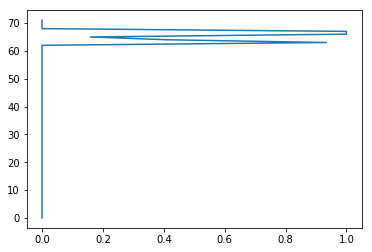

In [69]:
import matplotlib.pyplot as plt

plt.plot(test[2,:,-3], np.arange(72))
plt.show()